In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
import CBcm

In [2]:
from scipy import stats

import iminuit

In [3]:
sys.path.append('/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules')

In [4]:
common_settings = pickle.load(open('/home/jp/projects/atm_nu/ddm_results/final_settings/common_settings_daemon.pkl'))

In [5]:
import mufit
reload(mufit)
import mufit_plots as mfp
reload(mfp)

MUFIT: Using quickflux2!
MUFIT: Using quickflux2!
MufitPlots does not use the mceq flux evaluator directly
MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.pyc'>

In [14]:
fitname = 'prd22_daemon_v3minos'
filename = '/home/jp/projects/atm_nu/ddm_results/'+fitname+'.pkl'


In [7]:
fit = mufit.MuFit(datasets = ['bessfull',
                              'l3c', 
                              'opera', 
                              'minos',
                              'cms',
                              'deis',
                              'mutronratio',
                             'deisratio'],

                 flux_splines = 'daemon-v3',)


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/resources/daemonsplines_20230207_nousertab.pkl
Excluded params removed from known_params.
No calibration file for daemon-v3
Adjusting DEIS name
daemon-v3
('Using errors in mode: ', 'mixed')
MUTRON ratio: adding ALL errors in quadrature
DEIS ratio: adding ALL errors in quadrature


In [8]:
physics_params = common_settings['physics_params']
physics_params

[u'pi+_31G',
 u'pi-_31G',
 u'K+_31G',
 u'K-_31G',
 u'pi+_158G',
 u'pi-_158G',
 u'K+_158G',
 u'K-_158G',
 u'p_158G',
 u'n_158G',
 u'pi+_20T',
 u'pi-_20T',
 u'pi+_2P',
 u'pi-_2P',
 u'K+_2P',
 u'K-_2P',
 u'p_2P',
 u'n_2P',
 u'GSF_1',
 u'GSF_2',
 u'GSF_3',
 u'GSF_4',
 u'GSF_5',
 u'GSF_6']

In [9]:
my_flux_parameters = {}
for onep in physics_params:
    if 'GSF' in onep:
        my_flux_parameters[onep] = [0., False, -4, 4, 0., 1]
    elif ('31G' in onep) or ('158G' in onep):
        my_flux_parameters[onep] = [0., False, -10, 10, 0., 1]
    elif ('20T' in onep) or ('2P' in onep):
        if 'pi+' in onep:
            my_flux_parameters[onep] = [-0.3, False, -5., 5.,  0.,  2.]
        elif 'pi-' in onep:
            my_flux_parameters[onep] = [0,False, -33,  33,    0,  10]
        elif 'K+' in onep:
            my_flux_parameters[onep]= [ 0., False, -19,  19,  0,  10]
        elif 'K-' in onep:
            my_flux_parameters[onep]=[-20., False, -25,  30, 0.,  20.]
        elif 'p' in onep:
            my_flux_parameters[onep]=[12., False, -16, 16,  0., 6]
        elif 'n' in onep:
            my_flux_parameters[onep]=[0., False, -6, 6,   0,  2.5]
#for onep in physics_params:
#    print(onep, my_flux_parameters[onep])
    
mysyst = deepcopy(fit.systematics)
mysyst.update({# Fixing DEIS because errors are included by default
               'deis_mscat':  [0.0, True, -3, 3],
               'deis_bfield':  [0.0, True, -3, 3],
               'deis_norm':  [0.0, True, -3, 3],

               # L3c (all)
               'l3c_align': 0.0042, #np.random.uniform(-3,3),
               'l3c_bfield': -3.30, #np.random.uniform(-3,3),
               'l3c_eloss': -2.92, #np.random.uniform(-3,3),
               'l3c_overb': -0.5, #np.random.uniform(-3,3),
               'l3c_normHor': -1.41, #np.random.uniform(-3,3),
               'l3c_normVert': -1.591, #np.random.uniform(-3,3),
               'l3c_pres': 1.352, #np.random.uniform(-3,3),

               'mn_escale': -1.59, #np.random.uniform(-3,3),

               # Bess
               'bess_align': -1.72, #np.random.uniform(-3,3),
               'bess_finres': 0.2, #np.random.uniform(-3,3),
               })

In [10]:
# Check if there's a previous fit, start from there
if os.path.isfile(filename):
    old_result = pickle.load(open(filename,'rb'))
    
    for onekey in my_flux_parameters:
        my_flux_parameters[onekey][0] = old_result['params'][onekey]['value']
    for onekey in mysyst:
        if type(mysyst[onekey]) == list:
            mysyst[onekey][0] = old_result['params'][onekey]['value']    
        else:
            mysyst[onekey] = old_result['params'][onekey]['value'] 


In [11]:
nfits = 1
counter = 0
bestfit = 1E9
defprior = 60
for ifit in range(nfits):
    print 'Internal fit ', ifit
    
    # Start at best fit from previous fit
    if bestfit<1E9:
        for onekey in my_flux_parameters:
            my_flux_parameters[onekey][0] = fit.results['params'][onekey]['value']
        for onekey in mysyst:
            if type(mysyst[onekey]) == list:
                mysyst[onekey][0] = fit.results['params'][onekey]['value']    
            else:
                mysyst[onekey] = fit.results['params'][onekey]['value']  
            
    # Change some parameters slightly
    for i in range(4):
        randkey = my_flux_parameters.keys()[np.random.randint(len(my_flux_parameters))]
        my_flux_parameters[randkey][0] += np.random.normal()
    
    #print(my_flux_parameters)
    
    one_m, one_f = fit.run_fit(
        flux_parameters = my_flux_parameters,        
        exp_parameters = mysyst,
        fit_data = 'all',
        fit_mode = 'physics',
        use_priors = True,
        print_mode = False,
        dry_run = False,
        emin=5.,
        fake_data = False,
        )
    
    this_fit = fit.results['fmin']['fval']
    print 'This fit', this_fit
    if this_fit < bestfit:
        print 'Updated results for fit', this_fit, bestfit
        bestfit = deepcopy(this_fit)
        results = deepcopy(fit.results)
        m = one_m
        f = one_f

Internal fit  0


/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit.py:304: RuntimeWarning: invalid value encountered in divide
  phys_priors_mean)**2/phys_priors_err**2)[prior_bool]


Successful fit!
This fit 498.477621729
Updated results for fit 498.477621729 1000000000.0


In [12]:
free_params = 0
for one_param in fit.fit_keys:
    if not fit.minuit_settings['fix_'+one_param]:
        free_params += 1
#print(free_params, len(fit.fit_keys))

In [13]:
all_keys = results['params'].keys()
dof = fit.results['bins']-free_params
print 'Chi2',fit.results['chi2'], '/', dof, 'dof (approximate)'
p_value = 1-stats.chi2.cdf(fit.results['chi2'], dof)
print('P-value', p_value)
syst_keys = []
print '\t'.join(['Param', 'value','error'])
for one_param in physics_params:
    all_keys.remove(one_param)
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])
all_keys.sort()
for one_param in all_keys:
    print '\t'.join([one_param, 
                     "%0.2f" % results['params'][one_param]['value'],
                    "%0.2f" % results['params'][one_param]['error']])



Chi2 411.021755164197 / 424 dof (approximate)
('P-value', 0.6654377896598441)
Param	value	error
pi+_31G	-2.21	0.78
pi-_31G	-3.26	0.38
K+_31G	-1.96	0.76
K-_31G	-0.29	0.99
pi+_158G	0.13	0.10
pi-_158G	4.08	0.70
K+_158G	0.29	0.99
K-_158G	0.25	1.00
p_158G	0.32	0.95
n_158G	2.04	0.79
pi+_20T	-1.90	0.41
pi-_20T	-5.70	2.98
pi+_2P	-4.57	1.48
pi-_2P	-1.81	8.52
K+_2P	4.67	12.93
K-_2P	-22.35	49.94
p_2P	12.78	5.14
n_2P	3.69	2.25
GSF_1	0.89	0.92
GSF_2	0.37	0.99
GSF_3	0.12	0.99
GSF_4	0.59	0.99
GSF_5	-2.19	0.97
GSF_6	0.56	0.99
bess_align	-1.67	0.68
bess_finres	0.16	0.82
deis_bfield	0.00	0.50
deis_mscat	0.00	0.50
deis_norm	0.00	0.50
l3c_align	-0.02	0.07
l3c_bfield	-2.99	0.78
l3c_eloss	-2.41	0.79
l3c_normHor	-1.28	0.55
l3c_normVert	-1.17	0.52
l3c_overb	-0.20	0.49
l3c_pres	1.20	0.52
mn_escale	-1.66	0.32


In [15]:
one_m.minos()

-------------------------------------------------
|      K+_2P      |            Valid            |
-------------------------------------------------
|      Error      |      -4      |       7      |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|      p_2P       |            Valid            |
-------------------------------------------------
|      Error      |      -5      |       3      |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |     True     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|    pi-_158G     |            Valid            |
-------------------------------------------------
|      Error      |     -0.7     |      0.7     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|     pi+_2P      |            Valid            |
-------------------------------------------------
|      Error      |     -0.4     |      1.6     |
|      Valid      |     True     |     True     |
|    At Limit     |     True     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|      K-_2P      |            Valid            |
-------------------------------------------------
|      Error      |     -2.7     |     13.8     |
|      Valid      |     True     |     True     |
|    At Limit     |     True     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|     K-_31G      |            Valid            |
-------------------------------------------------
|      Error      |     -1.0     |      1.0     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|     n_158G      |            Valid            |
-------------------------------------------------
|      Error      |     -0.8     |      0.8     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|     pi+_31G     |            Valid            |
-------------------------------------------------
|      Error      |     -0.8     |      0.8     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|     K+_158G     |            Valid            |
-------------------------------------------------
|      Error      |     -1.0     |      1.0     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |


In [18]:
one_f

------------------------------------------------------------------
| FCN = 498.5                   |    Ncalls=3304 (3304 total)    |
| EDM = 4.15E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
|   | Name         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------
| 0 | K+_2P        |     5     |     13    |     -4     |      7     |   -19   |   19    |       |
| 1 | p_2P         |     13    |     5     |     -5     |      3     |   -16   |   16    |       |
| 2 | pi-_158G     |    4.1    |    0.7    |    -0.7    |     0.7    |   -10   |   10    |       |
| 3 | pi+_2P       |   -4.6    |    1.5    |    -0.4    |     1.6    |   -5    |    5    |       |
| 4 | K-_2P        |   -22.3   |    49.9   |    -2.7    |    13.8    |   -25   |   30    |       |
| 5 | K-_31G       |   -0.29   |    0.99   |   -0.99    |    0.99    |   -10   |   10    |       |
| 6 | n_158G       |    2.0    |    0.8    |    -0.8    |     0.8    |   -10   |   10    |       |
| 7 | pi+_31G      |   -2.2    |    0.8    |    -0.8    |     0.8    |   -10   |   10    |       |
| 8 | K+_158G      |    0.29   |    0.99   |   -0.98    |    0.97    |   -10   |   10    |       |
| 9 | K-_158G      |    0.25   |    1.00   |   -0.99    |    0.99    |   -10   |   10    |       |
| 10| pi-_20T      |   -5.7    |    3.0    |    -2.2    |     2.2    |   -33   |   33    |       |
| 11| pi+_158G     |    0.13   |    0.10   |   -0.10    |    0.10    |   -10   |   10    |       |
| 12| p_158G       |    0.3    |    1.0    |    -1.0    |     1.0    |   -10   |   10    |       |
| 13| GSF_4        |    0.6    |    1.0    |    -1.0    |     1.0    |   -4    |    4    |       |
| 14| GSF_5        |   -2.2    |    1.0    |    -1.0    |     1.0    |   -4    |    4    |       |
| 15| GSF_6        |    0.6    |    1.0    |    -1.0    |     1.0    |   -4    |    4    |       |
| 16| GSF_1        |    0.9    |    0.9    |    -0.9    |     0.9    |   -4    |    4    |       |
| 17| GSF_2        |    0.4    |    1.0    |    -1.0    |     1.0    |   -4    |    4    |       |
| 18| GSF_3        |    0.12   |    0.99   |   -1.00    |    1.00    |   -4    |    4    |       |
| 19| K+_31G       |   -2.0    |    0.8    |    -0.8    |     0.8    |   -10   |   10    |       |
| 20| pi+_20T      |   -1.9    |    0.4    |    -0.3    |     0.3    |   -5    |    5    |       |
| 21| pi-_31G      |   -3.3    |    0.4    |    -0.4    |     0.4    |   -10   |   10    |       |
| 22| pi-_2P       |   -1.8    |    8.5    |    -7.4    |     7.2    |   -33   |   33    |       |
| 23| n_2P         |    3.7    |    2.3    |    -2.4    |     2.3    |   -6    |    6    |       |
| 24| deis_norm    |    0.0    |    0.5    |            |            |   -3    |    3    |  yes  |
| 25| l3c_bfield   |   -3.0    |    0.8    |    -0.8    |     0.8    |   -5    |    5    |       |
| 26| l3c_overb    |   -0.20   |    0.49   |   -0.49    |    0.50    |   -5    |    5    |       |
| 27| mn_escale    |   -1.7    |    0.3    |    -0.3    |     0.4    |   -5    |    5    |       |
| 28| bess_align   |   -1.7    |    0.7    |    -0.7    |     0.7    |   -5    |    5    |       |
| 29| l3c_normVert |   -1.2 

In [20]:
profile_list = one_m.mnprofile('K-_2P')

In [54]:
profile_list[1].min()

498.5136030273705

(-30, 35)

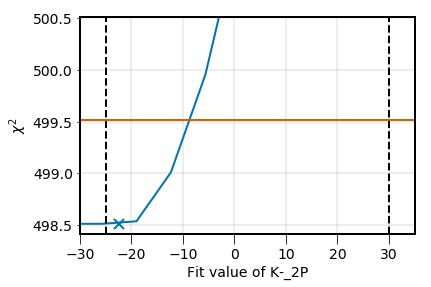

In [56]:
plt.plot(profile_list[0], profile_list[1], 'C1')
plt.plot(one_m.values['K-_2P'], profile_list[1].min(),  'x', color='C1', markersize=10)
plt.ylabel(r'$\chi^2$')
plt.xlabel('Fit value of K-_2P')
plt.axvline(-25, linestyle='--')
plt.axvline(30, linestyle='--')
plt.axhline(profile_list[1].min()+1, color='C4')
plt.ylim(profile_list[1].min()-0.1, profile_list[1].min()+2)
plt.xlim(-30, 35)

In [37]:
one_m.values['K-_2P']

-22.347923349086823

In [19]:
fit.results['flux_parameters'] = my_flux_parameters

In [20]:
fit.results['flux_tables']

'daemon-v3'

In [21]:
pickle.dump(fit.results, open(filename, 'wb'))
print('Written', filename)

('Written', '/home/jp/projects/atm_nu/ddm_results/prd22_daemon_v3.pkl')


In [22]:
fit.results['flux_parameters']

{u'GSF_1': [0.8834207723736194, False, -4, 4, 0.0, 1],
 u'GSF_2': [-0.2702388097417606, False, -4, 4, 0.0, 1],
 u'GSF_3': [0.116406003090896, False, -4, 4, 0.0, 1],
 u'GSF_4': [-0.9385712684995897, False, -4, 4, 0.0, 1],
 u'GSF_5': [-0.8251025738357125, False, -4, 4, 0.0, 1],
 u'GSF_6': [0.5627260578627791, False, -4, 4, 0.0, 1],
 u'K+_158G': [0.28751384632338883, False, -10, 10, 0.0, 1],
 u'K+_2P': [4.692126624026411, False, -19, 19, 0, 10],
 u'K+_31G': [-1.9575301513515626, False, -10, 10, 0.0, 1],
 u'K-_158G': [0.2542369622495144, False, -10, 10, 0.0, 1],
 u'K-_2P': [-22.276918433890074, False, -25, 30, 0.0, 20.0],
 u'K-_31G': [-0.2880397654279001, False, -10, 10, 0.0, 1],
 u'n_158G': [2.038215584610235, False, -10, 10, 0.0, 1],
 u'n_2P': [3.690275422227554, False, -6, 6, 0, 2.5],
 u'p_158G': [0.3165783468342891, False, -10, 10, 0.0, 1],
 u'p_2P': [12.781359725240478, False, -16, 16, 0.0, 6],
 u'pi+_158G': [0.12923302425609684, False, -10, 10, 0.0, 1],
 u'pi+_20T': [-1.8971621306559

In [23]:
m.matrix(correlation=True)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|              |        K+_2P         p_2P     pi-_158G       pi+_2P        K-_2P       K-_31G       n_158G      pi+_31G      K+_158G      K-_158G      pi-_20T     pi+_158G       p_158G        GSF_4        GSF_5        GSF_6        GSF_1        GSF_2        GSF_3       K+_31G      pi+_20T      pi-_31G       pi-_2P         n_2P   l3c_bfield    l3c_overb    mn_escale   bess_align l3c_normVert  l3c_normHor    l3c_eloss  bess_finres     l3c_pres    l3c_align |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        K+_2P |        1.000        0.079        0.023       -0.223        0.962       -0.001        0.061       -0.030        0.037       -0.031       -0.557        0.039        0.012        0.037       -0.135        0.045       -0.168        0.023        0.004       -0.033       -0.545       -0.077       -0.345        0.068        0.092        0.046        0.013        0.093       -0.017       -0.036        0.077        0.010        0.435        0.255 |
|         p_2P |        0.079        1.000       -0.129        0.035        0.097        0.004       -0.157        0.039        0.013       -0.005       -0.329       -0.220       -0.055       -0.006        0.021        0.000       -0.058       -0.004       -0.002        0.056       -0.372        0.114       -0.048       -0.114       -0.070       -0.021       -0.009       -0.091       -0.037       -0.023       -0.051        0.009        0.018       -0.007 |
|     pi-_158G |        0.023       -0.129        1.000        0.063        0.011        0.022       -0.474        0.084        0.030       -0.080        0.238        0.718       -0.142       -0.017        0.055        0.003       -0.285       -0.010       -0.003        0.105        0.251        0.215        0.108       -0.043        0.029       -0.104        0.009        0.163        0.041        0.001        0.008       -0.043       -0.050       -0.020 |
|       pi+_2P |       -0.223        0.035        0.063        1.000       -0.147       -0.002        0.040       -0.022        0.031       -0.010       -0.003        0.064        0.006        0.023       -0.082        0.027       -0.054        0.012        0.002       -0.032        0.036       -0.066        0.249        0.049       -0.077       -0.067       -0.087       -0.041       -0.021       -0.019       -0.062       -0.010       -0.021       -0.057 |
|        K-_2P |        0.962        0.097        0.011       -0.147        1.000       -0.002        0.094       -0.038        0.139       -0.073       -0.642       -0.072        0.007        0.042       -0.169        0.067       -0.151        0.029        0.006       -0.024       -0.542       -0.120       -0.472        0.128        0.087        0.050       -0.003        0.082       -0.020       -0.037        0.073        0.012        0.434        0.253 |
|       K-_31G |       -0.001        0.004        0.022       -0.002       -0.002        1.000       -0.029        0.013       -0.000        0.001       -0.002        0.010       -0.008        0.000       -0.001       -0.000        0.006        0.000        0.000        0.012       -0.005       -0.293       -0.

In [24]:
fit.results['cov_params'] = m.list_of_vary_param()
ordered_matrix = np.zeros_like(fit.results['corr_matrix'])
# Need to reorder this business
syst_params = ['l3c_bfield','l3c_overb','l3c_normVert', 'bess_align','bess_finres',
               'l3c_normHor','l3c_eloss','l3c_pres','l3c_align', 'mn_escale']
syst_params.sort()
ordered_phys = np.zeros(len(physics_params))
ordered_syst = np.zeros(len(syst_params))
for ip, one_param in enumerate(physics_params):
    ordered_phys[ip] = fit.results['cov_params'].index(one_param)
for ip, one_param in enumerate(syst_params):
    ordered_syst[ip] = fit.results['cov_params'].index(one_param)
    
full_list = physics_params + syst_params
full_in = np.array(np.concatenate((ordered_phys, ordered_syst)),dtype=int)
for j, one_param in enumerate(full_list):
    for k in range(len(full_in)):
        ordered_matrix[j,k] = fit.results['corr_matrix'][full_in[j], full_in[k]]

In [25]:
if not os.path.exists('/home/jp/projects/atm_nu/ddm_results/'+fitname):
    os.mkdir('/home/jp/projects/atm_nu/ddm_results/'+fitname)

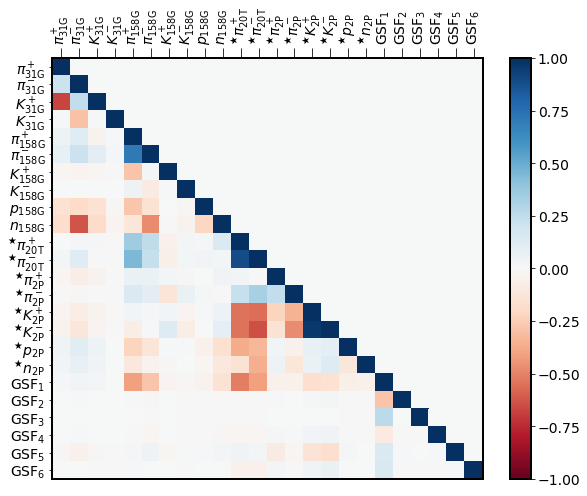

In [27]:
maxb = len(physics_params)
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]

    
fig = plt.figure(figsize=(12*0.7,10*0.7))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
plt.tight_layout()



fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_daemon.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/'+fitname+'/corr_phys_noscale_daemon.pdf')


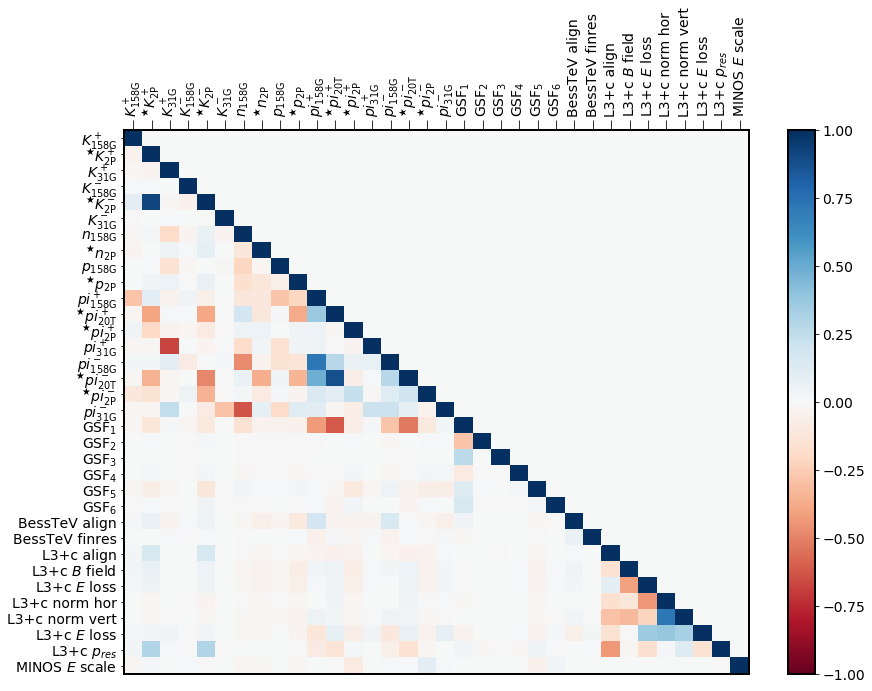

In [30]:
maxb = None
corr_matrix = deepcopy(ordered_matrix)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        if i<j: corr_matrix[i,j]=0.

params = deepcopy(full_list)

# Adjust parameter names
for i, onep in enumerate(params):
    params[i] = common_settings['param_legend'][onep]
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix.shape[0], 1.)
plt.pcolor(corr_matrix[:maxb,:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[:maxb], rotation=90)
plt.yticks(xmarks, params[:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full_daemon.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_full_daemon.pdf')


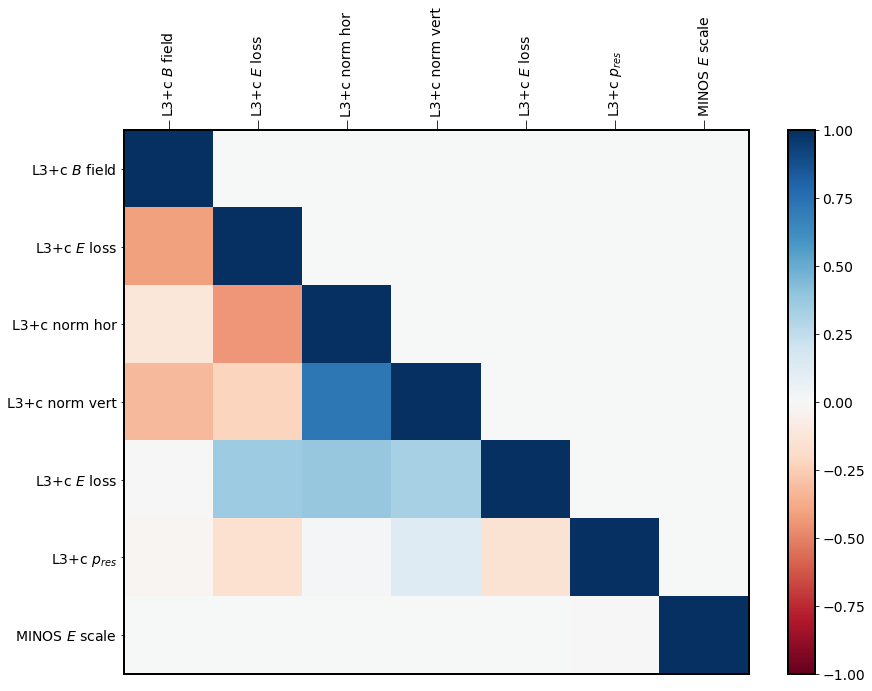

In [31]:
inb = 27
maxb = None
    
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
xmarks = np.arange(0.5, corr_matrix[inb:maxb,inb:maxb].shape[0], 1.)
plt.pcolor(corr_matrix[inb:maxb,inb:maxb], cmap='RdBu', vmin=-1, vmax=1)
plt.xticks(xmarks, params[inb:maxb], rotation=90)
plt.yticks(xmarks, params[inb:maxb])
plt.ylim(0,maxb)
plt.xlim(0,maxb)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
plt.colorbar()
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst_daemon.png', dpi=300)
fig.savefig('/home/jp/projects/atm_nu/ddm_results/prd22_results_may9_v12_final/corr_syst_daemon.pdf')


MufitPlots does not use the mceq flux evaluator directly
Flux deis 87.7076 [3.87014454e-01 5.29777889e-01 2.17372383e+00 9.39455017e+00
 5.10890594e+00 1.12657618e+01 8.87011331e+00 7.44386402e+00
 3.83217195e+00 5.10827509e+00 3.34858419e+00 3.90131524e+00
 9.87321058e-01 4.46515823e-01 1.19423652e+00 3.05474689e-01
 1.62422169e+00 1.35100837e-02 1.71421405e-01 6.82977429e-01
 1.16091022e+00 1.09639913e+00 3.46518133e-02 8.31449596e-01
 2.61481942e-02 1.06556169e-03]


/home/jp/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Flux l3c 38.0475 [2.77174541e-01 6.22395169e-02 6.44166461e-02 3.63387074e-01
 2.83358429e-02 6.25785830e-03 7.04822436e-01 5.05736903e-01
 1.25762019e+01]
Pull sum 292.4305419797228 118.59718792700393


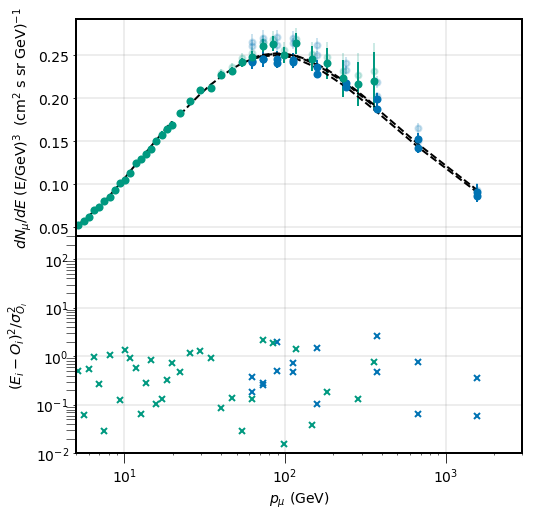

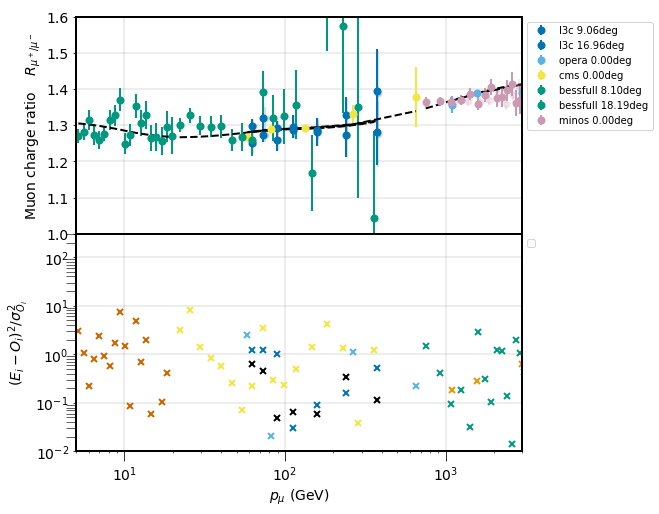

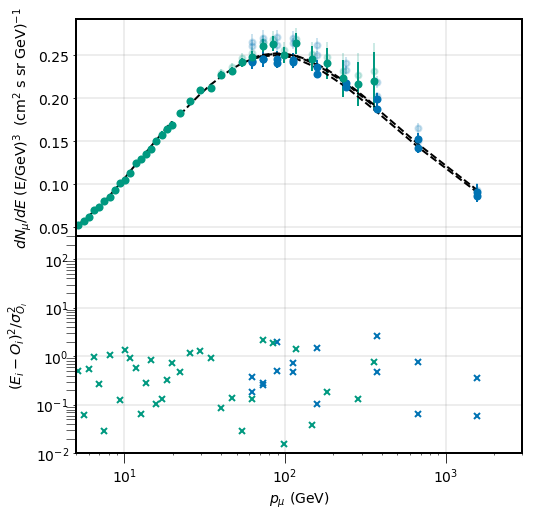

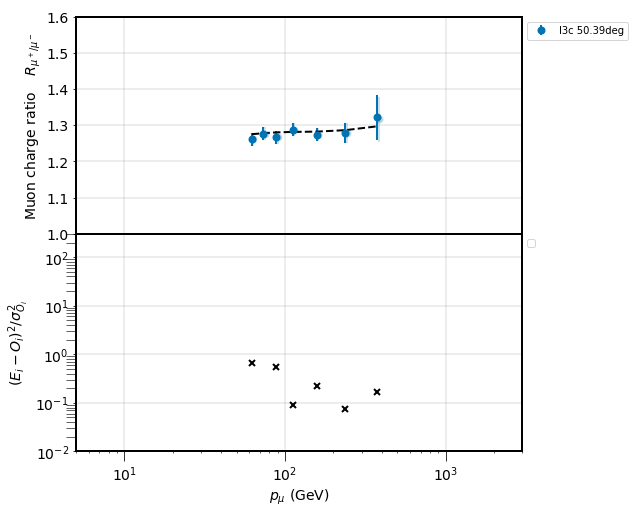

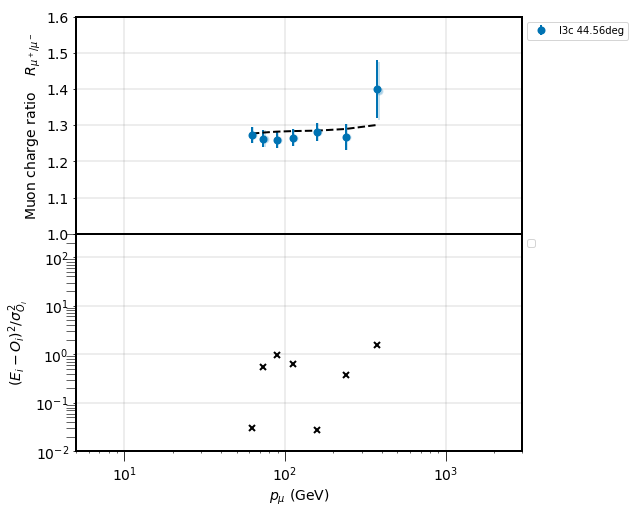

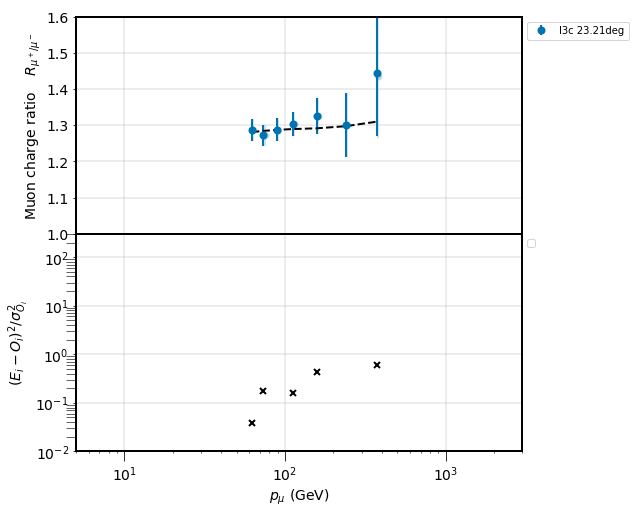

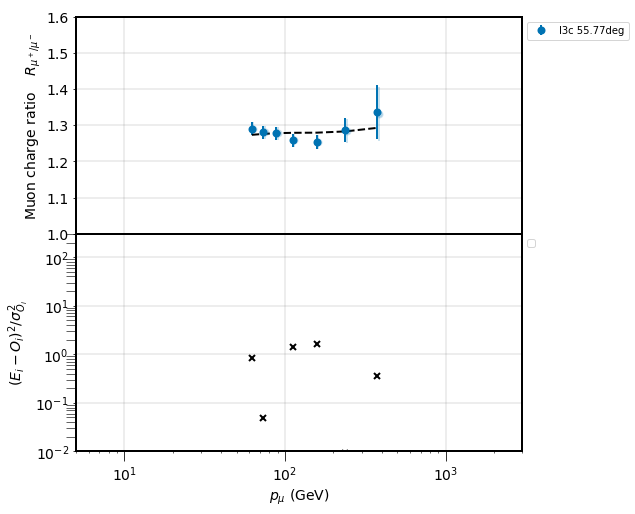

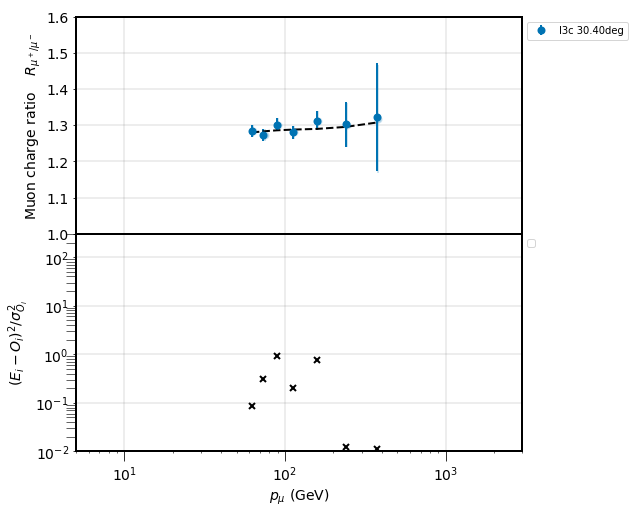

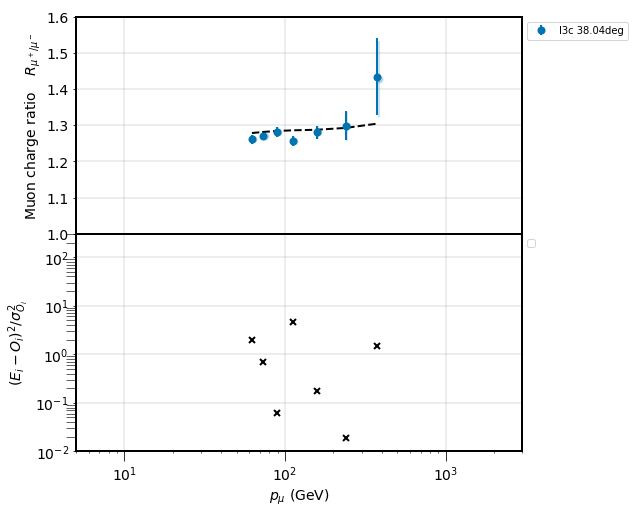

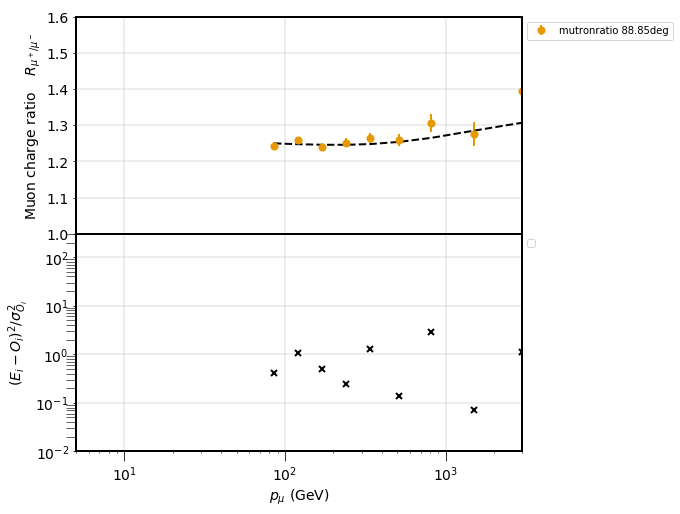

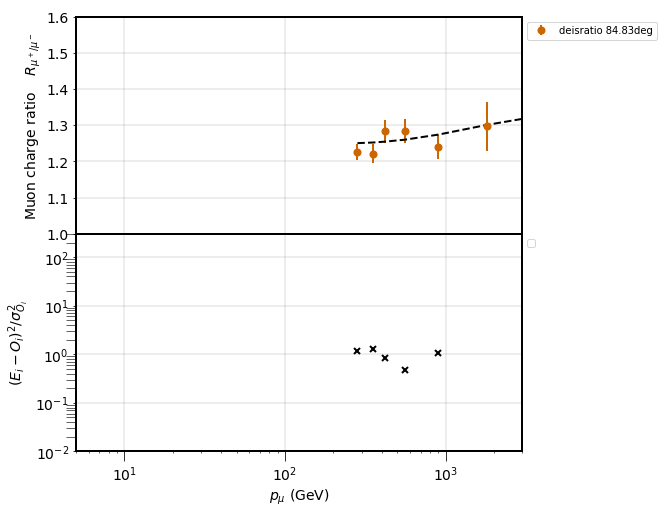

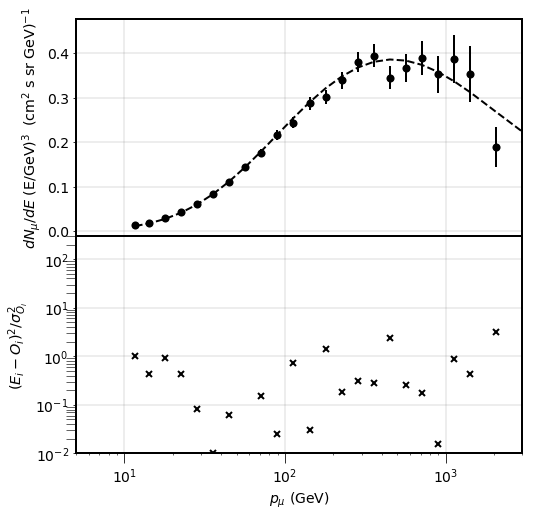

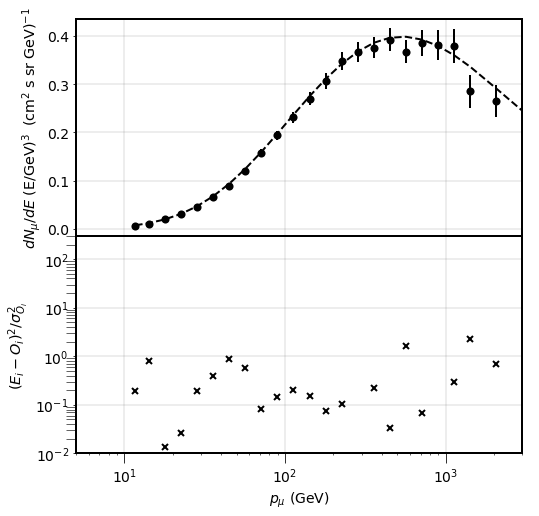

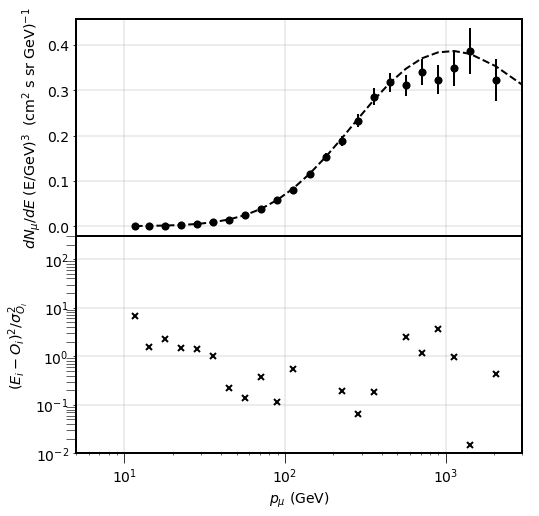

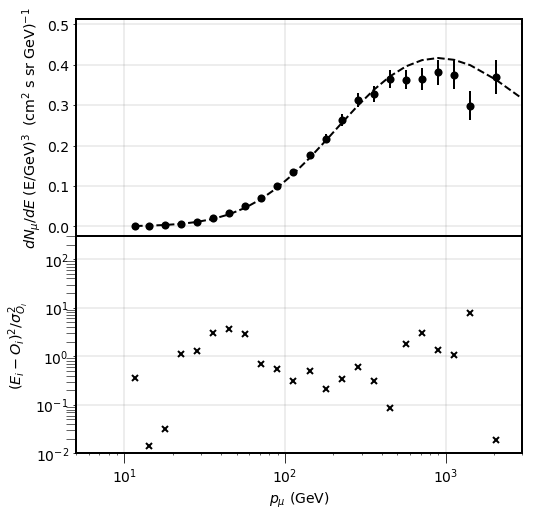

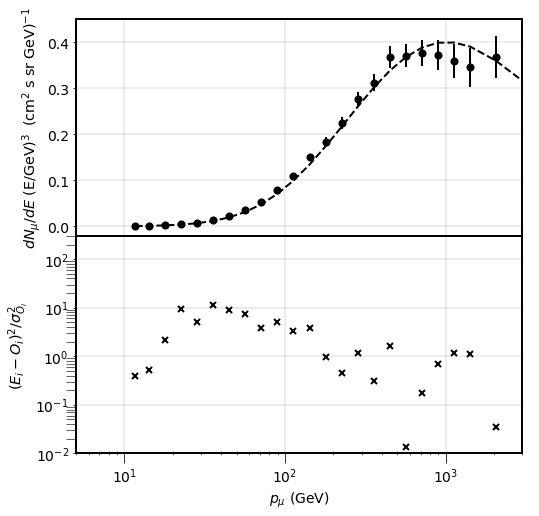

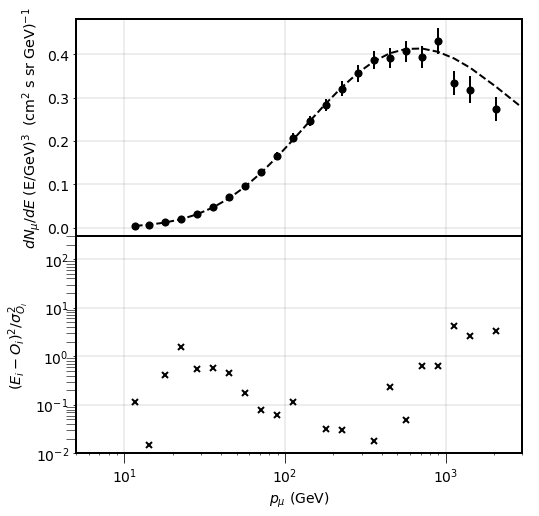

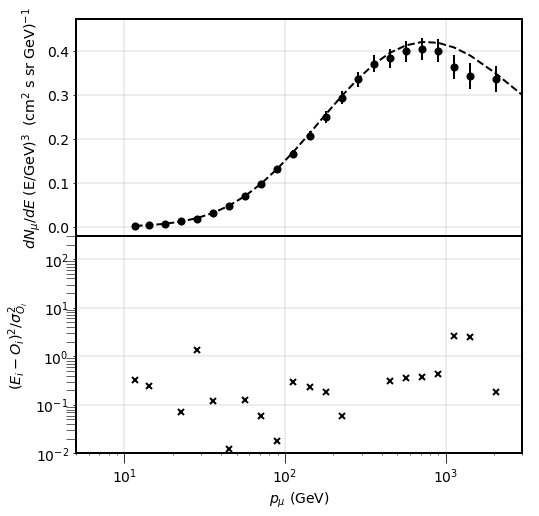

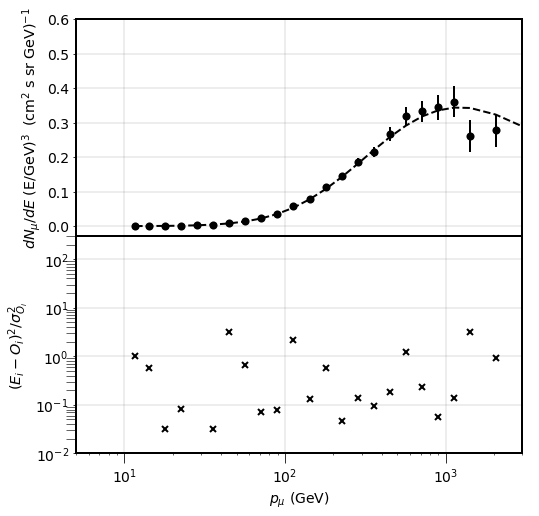

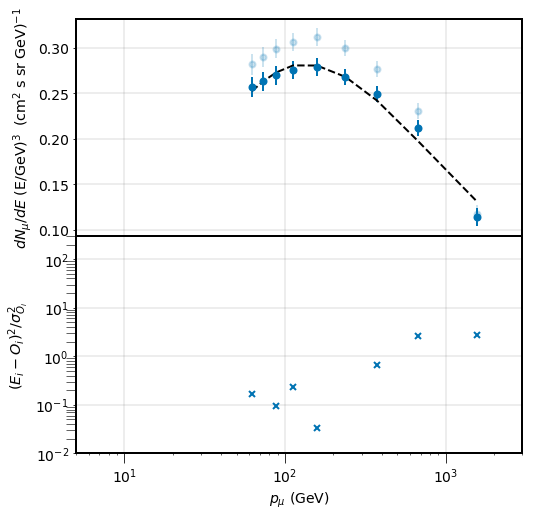

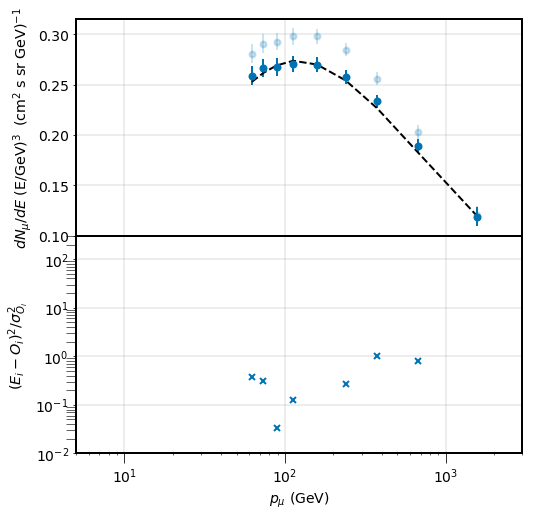

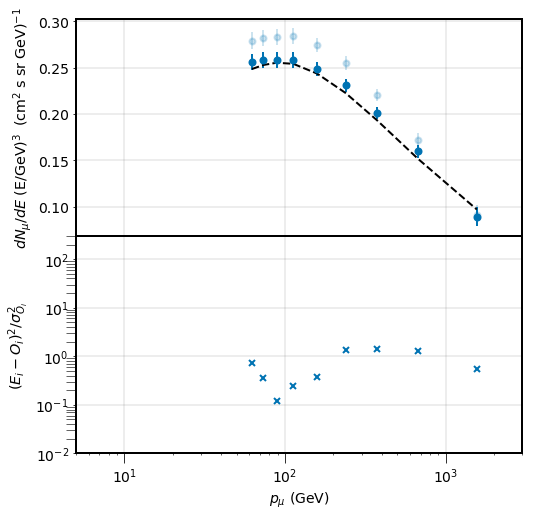

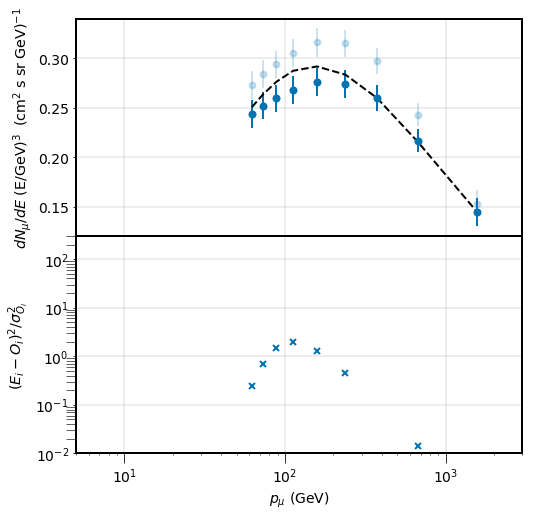

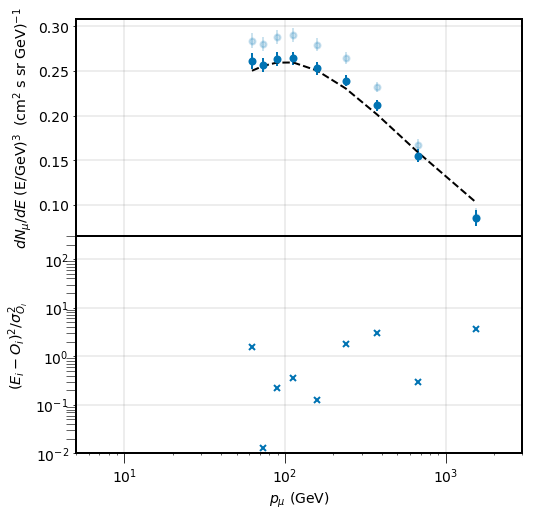

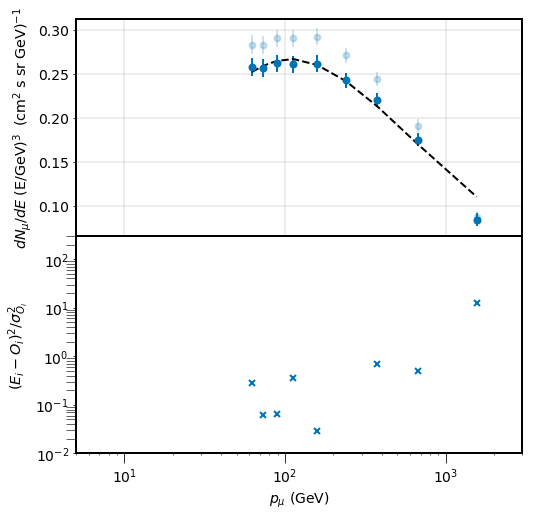

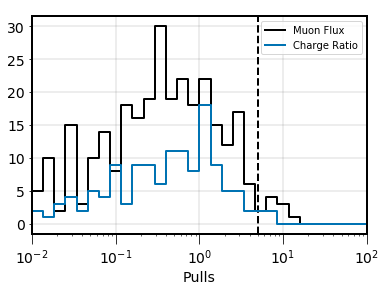

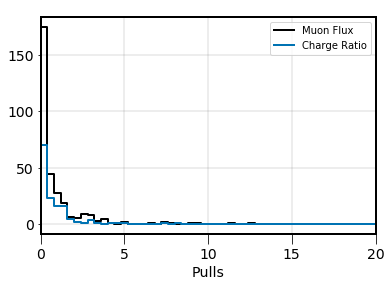

In [32]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
mfp.plot_comparison(fit, pullflag=10.,
                   emin=5)

In [45]:
reload(mfp)

MufitPlots does not use the mceq flux evaluator directly


<module 'mufit_plots' from '/home/jp/projects/atm_nu/mceq_tysak/muon_fit/modules/mufit_plots.py'>

 Figure with the following coszen angles [0.   0.05 0.1  0.15 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 5
l3c 44.5613 0.7777414039689492 6
l3c 23.2197 0.4052602163253273 9
l3c 55.7711 0.9733893224590094 4
l3c 30.4015 0.5306062725450561 8
l3c 9.0687 0.15827867387560976 11
l3c 16.9617 0.29603751173552223 10
l3c 38.0475 0.6640541471525425 7
bessfull 8.1096 0.14153922101973215 11
bessfull 18.1949 0.31756091207111625 10


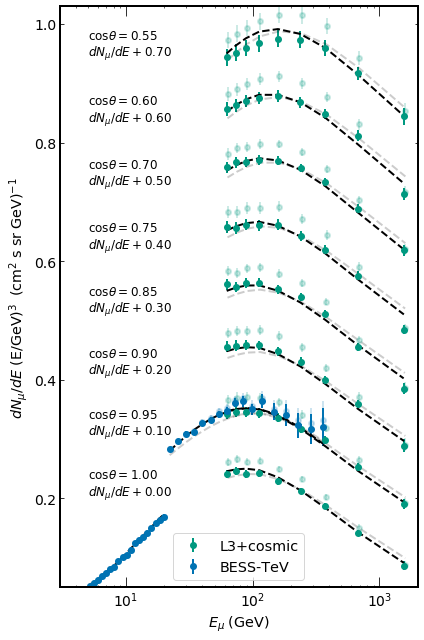

In [46]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
f1 = mfp.plotICRC21(fit, data_prefit = True)
f1.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_vert_daemon.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.   0.05 0.55 0.6  0.7  0.75 0.85 0.9  0.95 1.  ]
l3c 50.3943 0.8795464592377784 3
l3c 44.5613 0.7777414039689492 4
l3c 23.2197 0.4052602163253273 7
l3c 55.7711 0.9733893224590094 2
l3c 30.4015 0.5306062725450561 6
l3c 9.0687 0.15827867387560976 9
l3c 16.9617 0.29603751173552223 8
l3c 38.0475 0.6640541471525425 5
mutronratio 88.8540 1.5507948535670415 0
opera 0.0000 0.0 9
deisratio 84.8364 1.4806745055389174 1
cms 0.0000 0.0 9
bessfull 8.1096 0.14153922101973215 9
bessfull 18.1949 0.31756091207111625 8
minos 0.0000 0.0 9


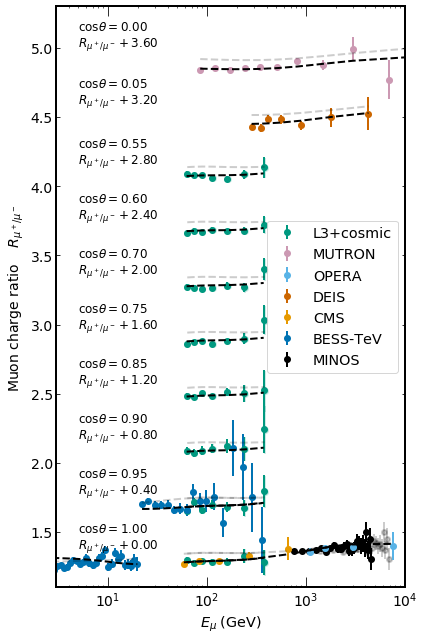

In [47]:
reload(mfp)
f2 = mfp.plotICRC21(fit, data= 'ratio',data_prefit = True)
f2.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/ratio_vert_daemon.pdf')

MufitPlots does not use the mceq flux evaluator directly
 Figure with the following coszen angles [0.01  0.025 0.035 0.055 0.085 0.115 0.16  0.19  1.   ]
deis 79.0472 0.19000027075775947 7
deis 80.7931 0.16000006510032283 6
deis 89.4270 0.010000569911261043 0
deis 88.2809 0.029999453593602104 1
deis 86.5602 0.059999777566286064 3
deis 87.7076 0.03999925401622205 2
deis 84.8364 0.08999987674362474 4
deis 83.1079 0.11999995530721862 5


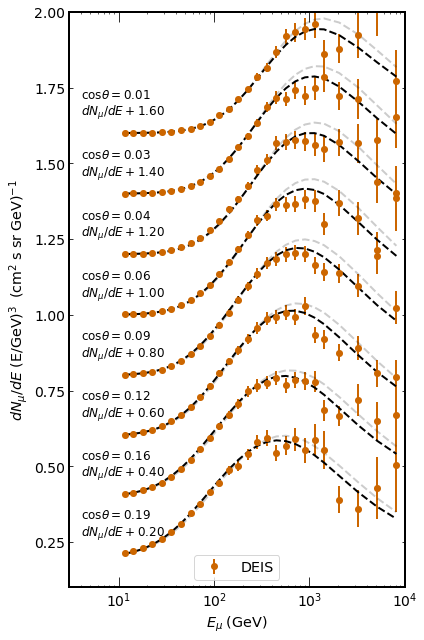

In [48]:
# Plots of the stored fit fluxes, ratios directly - does not evaluate splines again
reload(mfp)
f3 = mfp.plotICRC21(fit, data='deis', data_prefit = True)
f3.savefig('/home/jp/projects/atm_nu/ddm_results/muon_results/flux_deis_daemon.pdf')

In [ ]:
reload(mfp)
f1 = mfp.plotPulls(mufit=fit, pull_scale=20, log_pulls=False
                  )